In [60]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [61]:
import seaborn as sns

In [62]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [63]:
log_path = './yeast_radially_symmetric_nutrient_eating_rate_adjustable_timestep/log.txt'

In [64]:
import re

In [65]:
import pandas as pd

In [66]:
lookup_dict = {}
subgroup_dict = {}

# Variables to plot
lookup_dict['c'] = r'Solving for c, Initial residual = (\S*),'

lookup_dict['Ux'] = r'Solving for Ux, Initial residual = (\S*),'
lookup_dict['Uy'] = r'Solving for Uy, Initial residual = (\S*),'
lookup_dict['Uz'] = r'Solving for Uz, Initial residual = (\S*),'

lookup_dict['p_rgh'] = r'Solving for p_rgh, Initial residual = (\S*),'

lookup_dict['continuity'] = r'time step continuity errors : sum local = (\S*), global = (\S*), cumulative = (\S*)'
subgroup_dict['continuity'] = ['local', 'global', 'cumulative']

lookup_dict['courant'] = r'Courant Number mean: (\S*) max: (\S*)'
subgroup_dict['courant'] = ['mean', 'max']

# Important variables
global_dict = {}

global_dict['stokes_str'] = '^Finished stokes iteration (\S*)'
global_dict['time_str'] = '^Time = (\S*)'
global_dict['deltaT_str'] = '^deltaT = (\S*)'

In [67]:
# Create the corresponding lookup table
lookup_table = []

total_elapsed_iter = 0
cur_stokes_iter = 0
cur_time = 0.0
cur_deltaT = np.nan
with open(log_path) as fi:
    for line in fi:
        for key, cur_lookup in lookup_dict.iteritems():
            result = re.search(cur_lookup, line)
            if result is not None:
                for count, cur_value in enumerate(result.groups()):
                    if len(result.groups()) > 1:
                        key_str = key + '_' + subgroup_dict[key][count]
                    else:
                        key_str = key
                    lookup_table.append([key_str, cur_time, cur_deltaT, total_elapsed_iter, cur_stokes_iter, float(cur_value)])
        
        # Check if the line is important for global reasons
        for key, cur_lookup in global_dict.iteritems():
            result = re.search(cur_lookup, line)
            if result is not None:
                if key is 'stokes_str':
                    total_elapsed_iter += 1
                    cur_stokes_iter = int(result.groups()[0])
                if key is 'time_str':
                    cur_time = float(result.groups()[0])                        
                if key is 'deltaT_str':
                    cur_deltaT = float(result.groups()[0])

In [68]:
df = pd.DataFrame(data = lookup_table, columns=['key', 'time', 'deltaT', 'total_iter', 'cur_stokes_iter', 'value'])

In [69]:
plt.rc('text', usetex=False)

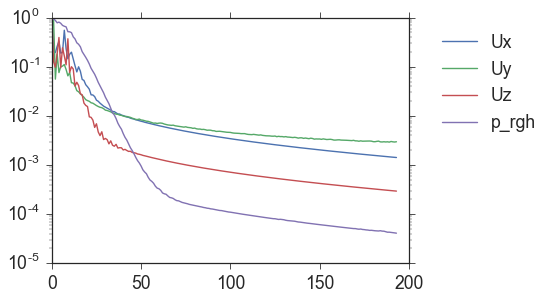

In [70]:
residuals_to_plot = ['Ux', 'Uy', 'Uz', 'p_rgh']

for name, cur_data in df.groupby('key'):
    if name in residuals_to_plot:
        plt.semilogy(cur_data['total_iter'], cur_data['value'], label=name)

plt.legend(bbox_to_anchor=(1.4, 1.0))

Ok. Very interesting. Let's try to tweak this so that it's better behaved.

In [71]:
df['key'].unique()

array(['courant_mean', 'courant_max', 'c', 'Ux', 'Uy', 'Uz', 'p_rgh',
       'continuity_local', 'continuity_global', 'continuity_cumulative'], dtype=object)

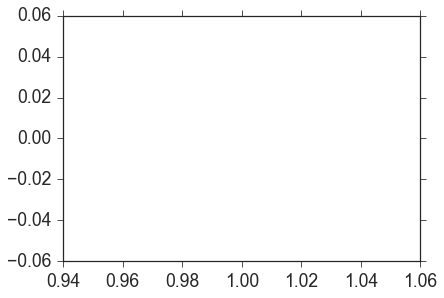

In [72]:
plt.plot(df.loc[df['key']=='courant_max']['value'])

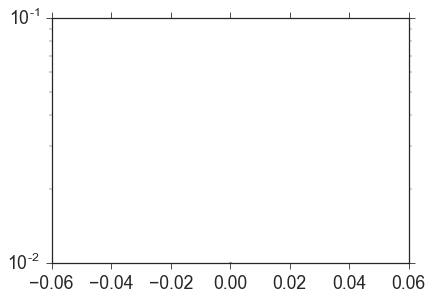

In [73]:
x = []
y = []
for name, cur_data in df.groupby(['time', 'deltaT']):
    x.append(name[0])
    y.append(name[1])
#plt.plot(x, y, ls='-', marker='.')
plt.figure()
plt.semilogy(y, ls='-', marker='.')